In [1]:
import pandas as pd
import numpy as np
from plotnine import *

%matplotlib inline

In [2]:
data = pd.read_csv("../../data/processed/expensas_full_processed_lag_3.csv",
                  dtype = {
                                "expensa_id": "object",
                                "unidad_id": "object",
                                "consorcio_id": "object",
                                "expensa_mes":"object",
                            },
                  parse_dates = ["expensa_fecha", "expensa_mes_pago", "expensa_mes_pago_anterior"])

In [3]:
data.shape

(193050, 21)

In [4]:
data.columns

Index(['expensa_id', 'consorcio_id', 'consorcio_nombre',
       'consorcio_cantidad_expensas', 'consorcio_prop_impagos',
       'consorcio_prop_efectivo', 'unidad_id', 'unidad_denominacion',
       'unidad_tipo', 'unidad_prop_impagos', 'expensa_proporcion',
       'expensa_interes_primer_vencimiento',
       'expensa_ineteres_segundo_vencimiento', 'expensa_mes', 'expensa_fecha',
       'expensa_mes_pago', 'expensa_mes_pago_anterior', 'pago_metodo_lag_1',
       'pago_metodo_lag_2', 'pago_metodo_lag_3', 'target'],
      dtype='object')

## Train-CV-Test Split Explanation

In [5]:
aux_df = data
aux_df = aux_df.sort_values("expensa_mes_pago").reset_index()

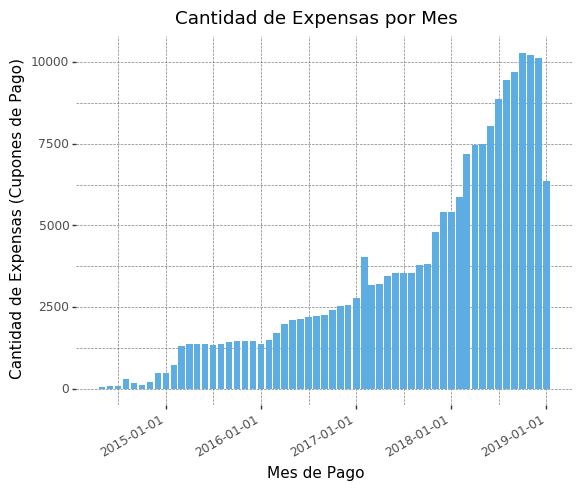

<ggplot: (-9223371857508751111)>

In [6]:
(ggplot(data=aux_df)
 + geom_bar(aes(x="expensa_mes_pago"), fill="#5DADE2")
 + theme(
     panel_background = element_rect(fill = "white"),
     panel_grid = element_line(color="grey", linetype="dashed", size=0.5),
     axis_text_x = element_text(angle = 30, hjust = 1)
 )
 + ylab("Cantidad de Expensas (Cupones de Pago)")
 + ggtitle("Cantidad de Expensas por Mes")
 + xlab("Mes de Pago")
)

In [7]:
test_size = round(len(aux_df) * 0.2)
cv_size = round(len(aux_df)*0.8*0.2)

In [8]:
from sklearn.model_selection import train_test_split
min_test_id = (aux_df.expensa_mes_pago < "2018-01-01").sum()
idxs = range(min_test_id, len(aux_df))
idx_train_cv, idx_test = train_test_split(idxs, shuffle = True, test_size =test_size)
idx_train, idx_cv = train_test_split(idx_train_cv, shuffle = True, test_size =cv_size)
idx_train += range(0, min_test_id)

In [9]:
aux_df["group"] = "0"
aux_df.loc[idx_train, "group"] = "train"
aux_df.loc[idx_cv, "group"] = "cv"
aux_df.loc[idx_test,"group"] = "test"

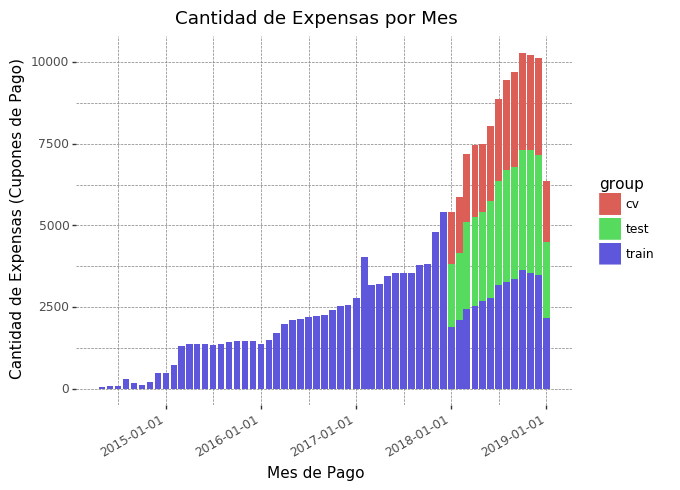

<ggplot: (-9223371857508544147)>

In [10]:
(ggplot(data=aux_df)
 + geom_bar(aes(x="expensa_mes_pago", fill="group"))
 + theme(
     panel_background = element_rect(fill = "white"),
     panel_grid = element_line(color="grey", linetype="dashed", size=0.5),
     axis_text_x = element_text(angle = 30, hjust = 1)
 )
 + ylab("Cantidad de Expensas (Cupones de Pago)")
 + ggtitle("Cantidad de Expensas por Mes")
 + xlab("Mes de Pago")
)

### Split

In [11]:
data = data.sort_values("expensa_mes_pago").reset_index().drop(columns="index")

In [12]:
X_columns  = [ 'consorcio_cantidad_expensas', 'consorcio_prop_impagos',
               'consorcio_prop_efectivo',
               'unidad_tipo', 'unidad_prop_impagos', 
               'expensa_proporcion',
               'expensa_interes_primer_vencimiento',
               'expensa_ineteres_segundo_vencimiento', 'expensa_mes',
               'pago_metodo_lag_1', 'pago_metodo_lag_2', 'pago_metodo_lag_3']

In [13]:
min_test_id = (data.expensa_mes_pago < "2018-01-01").sum()
idxs = range(min_test_id, len(data))
idx_train_cv, idx_test = train_test_split(idxs, shuffle = True, test_size =test_size)
idx_train_cv += range(0, min_test_id)

In [14]:
cv = list()
for i in range(0,3):
    idxs_train_cv2 = range(min_test_id, len(idx_train_cv))
    idx_train, idx_cv = train_test_split(idxs_train_cv2, shuffle = True, test_size =cv_size)
    idx_train += range(0, min_test_id)
    cv.append((idx_train, idx_cv))

In [16]:
X_train_cv = data.loc[idx_train_cv, X_columns + ["expensa_mes_pago"]].sort_values("expensa_mes_pago").reset_index().drop(columns=["index", "expensa_mes_pago"])
Y_train_cv = data.loc[idx_train_cv, ["target","expensa_mes_pago"]].sort_values("expensa_mes_pago").reset_index().drop(columns=["index", "expensa_mes_pago"])
X_test = data.loc[idx_test,X_columns]
Y_test = data.loc[idx_test, ["target"]]

## Dummies y Scaler

In [17]:
X_train_cv = pd.get_dummies(X_train_cv)
X_test = pd.get_dummies(X_test)

In [18]:
delete_columns = [column for column in X_test.columns if column not in X_train_cv.columns]
X_test = X_test.drop(columns = delete_columns)

In [19]:
print(X_train_cv.shape)
print(X_test.shape)

(154440, 42)
(38610, 42)


In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train_cv[["consorcio_cantidad_expensas"]])
X_train_cv.consorcio_cantidad_expensas = scaler.transform(X_train_cv[["consorcio_cantidad_expensas"]])
X_test.consorcio_cantidad_expensas = scaler.transform(X_test[["consorcio_cantidad_expensas"]])

## Xgboost

In [24]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth":[3,5],
    "learning_rate": [0.1, 0.01],
    "n_estimators": [100,1000],
    "reg_alpha": [0, 0.1, 0.01],
}

xgb = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid= param_grid,
    cv = cv,
    verbose = 10,
    n_jobs = -1,
    scoring = "f1"
)

In [25]:
xgb.fit(X_train_cv.values, Y_train_cv.values)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done  65 out of  72 | elapsed: 27.8min remaining:  3.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 30.7min finished
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionW

GridSearchCV(cv=[([121292, 154153, 113115, 118133, 108278, 122761, 147359, 90303, 134459, 141448, 88379, 135034, 138683, 141848, 107730, 87554, 141635, 128795, 140258, 154001, 101122, 126675, 152882, 94875, 124058, 127459, 93321, 117358, 132307, 99815, 133882, 151002, 139162, 119891, 112496, 107697, 144736, 1509...4, 137160, 153741, 133049, 153639, 104096, 126715, 126480, 117337, 138299, 112838, 109100, 101297])],
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 5], 'learning_rate': [0.1, 0.01], 'n_estimators': [10

In [28]:
xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 1000, 'reg_alpha': 0.1}

In [42]:
import pickle
with open('../../models/xgb_lag3.pkl', 'wb') as file:
    pickle.dump(xgb, file)

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
train_preds = xgb.predict(X_train_cv.values)
print("accuracy:", accuracy_score(Y_train_cv, train_preds))
print("precision:", precision_score(Y_train_cv, train_preds))
print("recall:", recall_score(Y_train_cv, train_preds))
print("f1:", f1_score(Y_train_cv, train_preds))
print("--------------------------------------------------")
test_preds = xgb.predict(X_test.values)
print("accuracy:", accuracy_score(Y_test, test_preds))
print("precision:", precision_score(Y_test, test_preds))
print("recall:", recall_score(Y_test, test_preds))
print("f1:", f1_score(Y_test, test_preds))

accuracy: 0.9056008806008806
precision: 0.8722785022667487
recall: 0.7568289425761806
f1: 0.8104629545365903
--------------------------------------------------
accuracy: 0.8884226884226885
precision: 0.8032383419689119
recall: 0.6897664071190212
f1: 0.7421903052064632


## Analisis de Coeficientes

In [30]:
xgb_importances = pd.DataFrame({
    "variable": X_train_cv.columns,
    "importance": xgb.best_estimator_.feature_importances_
})

In [32]:
from pandas.api.types import CategoricalDtype
xgb_importances = xgb_importances.sort_values("importance", ascending = False)
xgb_importances = xgb_importances.reset_index().drop(columns="index")

variable_cat = CategoricalDtype(categories=xgb_importances.variable, ordered=True)
xgb_importances.variable = xgb_importances.variable.astype(variable_cat)

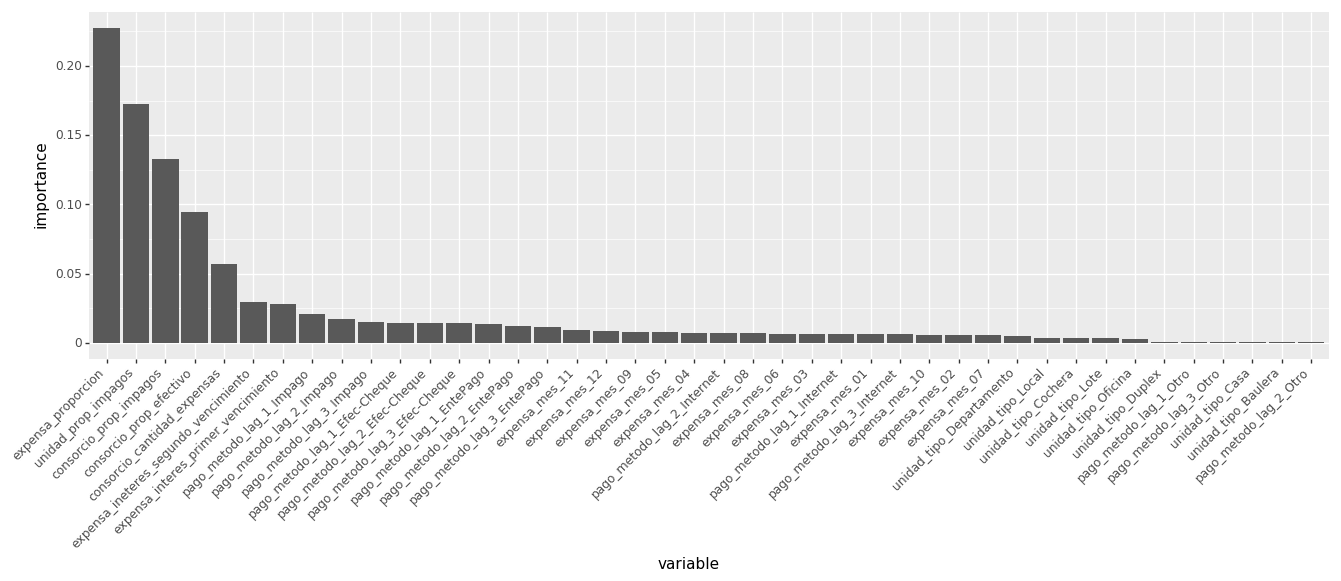

<ggplot: (-9223371857501562308)>

In [34]:
figure_size = (16, 4.8)
(ggplot(data=xgb_importances)
+ geom_bar(aes(x = "variable",y="importance"), stat = "identity")
+ theme( axis_text_x = element_text(angle = 45, hjust = 1),
          figure_size = (16, 4.5))
)

### Analisis de errores

In [35]:
data_test = data.loc[idx_test,:]
data_test["predicted"] = test_preds
data_test_por_consorcio = data_test[["consorcio_id", "consorcio_nombre", "target", "predicted"]]
data_test_por_consorcio["TP"] = data_test_por_consorcio.target.map(bool) & data_test_por_consorcio.predicted.map(bool)
data_test_por_consorcio["TN"] = ~data_test_por_consorcio.target.map(bool) & ~data_test_por_consorcio.predicted.map(bool)
data_test_por_consorcio["FP"] = ~data_test_por_consorcio.target.map(bool) & data_test_por_consorcio.predicted.map(bool)
data_test_por_consorcio["FN"] = data_test_por_consorcio.target.map(bool) & ~data_test_por_consorcio.predicted.map(bool)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html

In [36]:
data_test_por_consorcio = data_test_por_consorcio.groupby(["consorcio_id","consorcio_nombre"]).sum()

In [37]:
data_test_por_consorcio["Total"] = data_test_por_consorcio.TP + data_test_por_consorcio.TN + data_test_por_consorcio.FP + data_test_por_consorcio.FN
data_test_por_consorcio["PP"] = data_test_por_consorcio.TP + data_test_por_consorcio.FP
data_test_por_consorcio["PN"] = data_test_por_consorcio.TN + data_test_por_consorcio.FN
data_test_por_consorcio["RP"] = data_test_por_consorcio.TP + data_test_por_consorcio.FN
data_test_por_consorcio["RN"] = data_test_por_consorcio.FP + data_test_por_consorcio.TN
data_test_por_consorcio["accuracy"] = (data_test_por_consorcio.TP + data_test_por_consorcio.TN)/data_test_por_consorcio.Total
data_test_por_consorcio["precision"] = (data_test_por_consorcio.TP)/data_test_por_consorcio.PP
data_test_por_consorcio["recall"] = data_test_por_consorcio.TP / data_test_por_consorcio.RP

In [38]:
data_test_por_consorcio[["TP","TN","FP","FN", "Total","accuracy", "precision", "recall"]].sort_values("accuracy", ascending = True)

,,TP,TN,FP,FN,Total,accuracy,precision,recall
consorcio_id,consorcio_nombre,,,,,,,,
1805,Tucuman,0.0,2.0,1.0,1.0,4.0,0.500000,0.000000,0.000000
1445,EL NOGAL,10.0,12.0,5.0,14.0,41.0,0.536585,0.666667,0.416667
1736,Edificio Runa IV,3.0,15.0,5.0,7.0,30.0,0.600000,0.375000,0.300000
1850,CONSORCIO CENTRAL,1.0,2.0,1.0,1.0,5.0,0.600000,0.500000,0.500000
1530,EDIFICIO SAFIRA III,19.0,18.0,14.0,9.0,60.0,0.616667,0.575758,0.678571
1868,Juliana\t,2.0,5.0,2.0,1.0,10.0,0.700000,0.500000,0.666667
1847,Brown 1842,0.0,5.0,0.0,2.0,7.0,0.714286,NaN,0.000000
1681,Constitucion 1396,0.0,21.0,4.0,4.0,29.0,0.724138,0.000000,0.000000
1593,Consorcio Juan Guerra,6.0,10.0,2.0,4.0,22.0,0.727273,0.750000,0.600000


In [48]:
data_test_por_consorcio.accuracy.mean()

0.8662344158979725

In [47]:
data.loc[(data.consorcio_id == "1464") & (data.expensa_mes_pago >= '2018-01-01')
         ,[ 'unidad_id', 'unidad_denominacion', 'expensa_mes_pago',
                                       'consorcio_cantidad_expensas', 'consorcio_prop_impagos',
                                       'consorcio_prop_efectivo',
                                       'unidad_tipo', 'unidad_prop_impagos', 
                                       'expensa_proporcion',
                                       'expensa_interes_primer_vencimiento',
                                       'expensa_ineteres_segundo_vencimiento', 'expensa_mes',
                                       'pago_metodo_lag_3','pago_metodo_lag_2','pago_metodo_lag_1', 
                                       'target']].sort_values(["expensa_mes_pago", "unidad_id"])

,unidad_id,unidad_denominacion,expensa_mes_pago,consorcio_cantidad_expensas,consorcio_prop_impagos,consorcio_prop_efectivo,unidad_tipo,unidad_prop_impagos,expensa_proporcion,expensa_interes_primer_vencimiento,expensa_ineteres_segundo_vencimiento,expensa_mes,pago_metodo_lag_3,pago_metodo_lag_2,pago_metodo_lag_1,target
87353,25834,Pb A,2018-01-01,24.0,0.000000,0.583333,Departamento,0.050000,0.0442,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
87324,25835,Pb B,2018-01-01,24.0,0.000000,0.583333,Departamento,0.050000,0.0726,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
86908,25836,Pb C,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0368,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
87079,25837,Pb D,2018-01-01,24.0,0.000000,0.583333,Departamento,0.100000,0.0368,2.5,2.5,12,EntePago,Efec-Cheque,EntePago,0.0
87057,25838,Pb E,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0395,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
86901,25839,Pb F,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0372,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
87176,25840,Pb G,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0379,2.5,2.5,12,Efec-Cheque,Efec-Cheque,Efec-Cheque,0.0
86654,25841,1A,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0436,2.5,2.5,12,EntePago,Efec-Cheque,Efec-Cheque,0.0
86820,25842,1B,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0454,2.5,2.5,12,EntePago,EntePago,EntePago,0.0
86721,25843,1C,2018-01-01,24.0,0.000000,0.583333,Departamento,0.000000,0.0431,2.5,2.5,12,EntePago,EntePago,EntePago,0.0
